# GEDI Aboveground Biomass
## Overview
This tutorial will demonstrate how to directly access and subset the GEDI L4A dataset using [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov/) and compute a summary of aboveground biomass density for a protected area in Mexico. The Harmony API allows seamless access and production of analysis-ready Earth observation data across different DAACs by enabling cloud-based spatial, temporal, and variable subsetting and data conversions. The GEDI L4A dataset is available from the Harmony API.

```{admonition} Learning Objectives
- Use [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov/) to retrieve the GEDI L4A dataset. The Harmony API allows access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.
- Compute summaries of AGBD across various plant functional types (PFTs) in the study area.
```

## Dataset
The Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD) dataset {cite:p}`dubayah_2022` provides predictions of the aboveground biomass density (AGBD; in Mg/ha) and estimates of the prediction standard error within each sampled geolocated GEDI footprint. GEDI L4A dataset is available for the period starting 2019-04-17 and covers 52 N to 52 S latitudes. GEDI L4A data files are natively in HDF5 format. 
```{bibliography}
:style: plain
:filter: docname in docnames
```

In [10]:
import h5py
import requests as re
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
from harmony import Client, Collection, Environment, Request
import seaborn as sns
from os import path
sns.set(style='whitegrid')

## Authentication
NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can use the [earthaccess](https://nsidc.github.io/earthaccess/) Python library to set up authentication. Alternatively, you can also login to harmony_client directly by passing EDL authentication as the following in the Jupyter Notebook itself:
```bash
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

## Create Harmony Client Object
First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with the `auth` parameter.

In [2]:
harmony_client = Client()

## Retrieve Concept ID
Now, let’s retrieve the `Concept ID` of the GEDI L4A dataset. The `Concept ID` is NASA Earthdata’s unique ID for its dataset.

In [3]:
# GEDI L4A DOI 
doi = '10.3334/ORNLDAAC/2056'

# CMR API base url
doisearch = f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}' 
concept_id = re.get(doisearch).json()['feed']['entry'][0]['id']
concept_id

'C2237824918-ORNL_CLOUD'

## Define Request Parameters

Let’s create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L4A variables of interest and temporal range.

In [4]:
collection = Collection(id=concept_id)
# gedi beams
beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
# gedi variables
variables = ['agbd', 'l4_quality_flag', 'elev_lowestmode', 'land_cover_data/pft_class']
# combine variables and beams
variables = [f'/{b}/{v}' for b in beams for v in variables]
temporal_range = {'start': datetime(2019, 4, 17), 
                  'stop': datetime(2023, 3, 31)}

We will use the spatial extent of the [Reserva Florestal Adolpho Ducke](https://ppbio.inpa.gov.br/en/Sites/RFAD), a forest reserve near Manaus, Brazil, provided as a GeoJSON file at `assets/reserva_ducke.json`. Let’s open and plot this file.

In [5]:
poly_json = 'assets/reserva_ducke.json'
poly = gpd.read_file(poly_json) 
poly.explore(color='red',  fill=False)

## Create and Submit Harmony Request
Now, we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded.

In [6]:
request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  shape=poly_json,
                  ignore_errors=True)

# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)

print(f'Processing job: {subset_job_id}')

print(f'Waiting for the job to finish')
results = harmony_client.result_json(subset_job_id, show_progress=True)

print(f'Downloading subset files...')
futures = harmony_client.download_all(subset_job_id, directory="downloads", overwrite=False)
for f in futures:
    # all subsetted files have this suffix
    if f.result().endswith('subsetted.h5'):
        print(f'Downloaded: {f.result()}')
            
print(f'Done downloading files.')

Processing job: 6d74cf1a-7f37-4f37-89bf-6b203bbcfdd7
Waiting for the job to finish


 [ Processing:  78% ] |#######################################            | [\]
Job is running with errors.
 [ Processing: 100% ] |###################################################| [|]


downloads/75810914_GEDI04_A_2019167212927_O02889_04_T02025_02_002_02_V002_subsetted.h5
Downloaded: downloads/75810914_GEDI04_A_2019167212927_O02889_04_T02025_02_002_02_V002_subsetted.h5
downloads/75810915_GEDI04_A_2019193112046_O03286_04_T04871_02_002_02_V002_subsetted.h5
Downloaded: downloads/75810915_GEDI04_A_2019193112046_O03286_04_T04871_02_002_02_V002_subsetted.h5
downloads/75810916_GEDI04_A_2019223115656_O03752_01_T00916_02_002_02_V002_subsetted.h5
Downloaded: downloads/75810916_GEDI04_A_2019223115656_O03752_01_T00916_02_002_02_V002_subsetted.h5
downloads/75810917_GEDI04_A_2019242043202_O04042_01_T02492_02_002_02_V002_subsetted.h5
Downloaded: downloads/75810917_GEDI04_A_2019242043202_O04042_01_T02492_02_002_02_V002_subsetted.h5
downloads/75810918_GEDI04_A_2019287103704_O04744_01_T03762_02_002_02_V002_subsetted.h5
Downloaded: downloads/75810918_GEDI04_A_2019287103704_O04744_01_T03762_02_002_02_V002_subsetted.h5
downloads/75810920_GEDI04_A_2021123022615_O13529_01_T08031_02_002_02_V

## Read Subset files
All the subsetted files are saved as `_subsetted.h5`. Let’s read these `h5` files into the pandas dataframe.


In [11]:
subset_df = pd.DataFrame()
for subfile in glob(path.join('downloads', '*_subsetted.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            col_names = []
            col_val = []
            # read all variables
            for key, value in beam.items():
                # check if the item is a group
                if isinstance(value, h5py.Group):
                    # looping through subgroups
                    for key2, value2 in value.items():
                        col_names.append(key2)
                        col_val.append(value2[:].tolist())
                else:
                    col_names.append(key)
                    col_val.append(value[:].tolist())

        # Appending to the subset_df dataframe
        beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
        subset_df = pd.concat([subset_df, beam_df])
    hf_in.close()
# print head of dataframe
subset_df.head()

,agbd,delta_time,elev_lowestmode,lat_lowestmode_a1,lon_lowestmode_a1,shot_number,l4_quality_flag,pft_class,shot_number,lat_lowestmode,lon_lowestmode,shot_number
0,-9999.0,1.271338e+08,5994.854492,-2.917103,-59.941060,174550000400286136,0,2,174550000400286136,-2.917103,-59.941060,174550000400286136
1,-9999.0,1.271338e+08,5995.035645,-2.917524,-59.940762,174550000400286137,0,2,174550000400286137,-2.917524,-59.940762,174550000400286137
2,-9999.0,1.271338e+08,5994.925781,-2.917944,-59.940464,174550000400286138,0,2,174550000400286138,-2.917944,-59.940464,174550000400286138
3,-9999.0,1.271338e+08,5995.046387,-2.918365,-59.940166,174550000400286139,0,2,174550000400286139,-2.918365,-59.940166,174550000400286139
4,-9999.0,1.271338e+08,5995.626465,-2.918786,-59.939868,174550000400286140,0,2,174550000400286140,-2.918786,-59.939868,174550000400286140


# Quality Filter and Plot
We can now quality filter the dataset and only retrieve the good quality shots for trees and shrub cover plant functional types (PFTs).

In [12]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies', 
              1: 'Evergreen Needleleaf Trees', 
              2: 'Evergreen Broadleaf Trees', 
              3: 'Deciduous Needleleaf Trees',  
              4: 'Deciduous Broadleaf Trees', 
              5: 'Shrub', 
              6: 'Grass',
              7: 'Cereal Croplands', 
              8: 'Broadleaf Croplands', 
              9: 'Urban and Built-up Lands', 
              10: 'Permanent Snow and Ice', 
              11: 'Barren', 
              255: 'Unclassified'}

# create geopandas dtframe
gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode), crs="EPSG:4326")
# creating mask with good quality shots and trees/shrubs pft class
mask = (gdf['l4_quality_flag']==1) & (gdf['pft_class'] <= 5 )

In [25]:
gdf = gdf[['lat_lowestmode', 'lon_lowestmode', 'elev_lowestmode', 'pft_class', 'agbd', 'geometry']]
gdf[mask].explore("agbd", vmax=300, cmap = "YlGn", alpha=0.5, radius=10, legend=True)

We will plot the distribution of the AGBD by plant functional types (PFTs) for good quality shots.

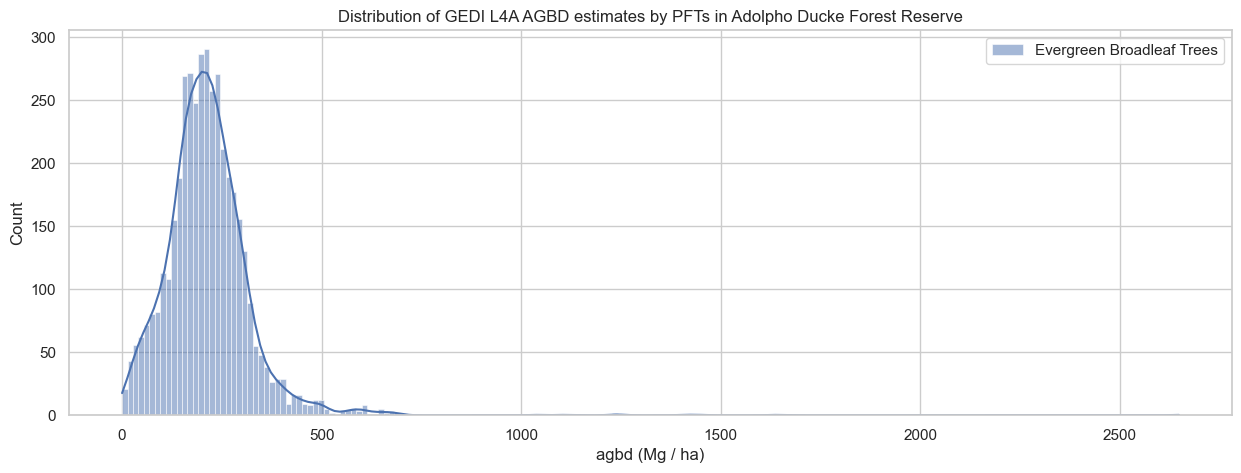

In [26]:
plt.figure(figsize=(15,5))
ax = gdf[mask].groupby('pft_class')['agbd'].\
            apply(lambda x: sns.histplot(x, label = pft_legend[x.name], kde=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs in Adolpho Ducke Forest Reserve')
plt.legend()
plt.show()

Let’s also plot how the AGBD is distributed across elevation ranges for different PFTs.


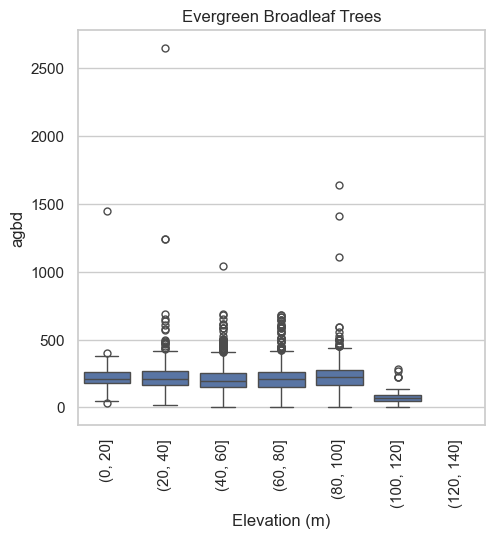

In [32]:
gdf['elev_bin']=pd.cut(gdf['elev_lowestmode'], bins =range(0, 160, 20))
g = sns.catplot(x = "elev_bin", y = "agbd", data = gdf[mask], col="pft_class", kind="box")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_title(pft_legend[int(float(ax.get_title()))])
g.set_axis_labels("Elevation (m)")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)